<a href="https://colab.research.google.com/github/Steelcrawler/CANISDataVizPrj/blob/main/ImageModelTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import os
from google.colab import userdata
import numpy as np
import matplotlib.pyplot as plt
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__

'2.2.1+cu121'

In [3]:
device

'cpu'

In [ ]:
# Downloading dataset
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels/
!unzip \*.zip  && rm *.zip
!rm -rf data/
!rmdir data/

In [5]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
walk_through_dir('/content/Lung Segmentation')

there are 5 directories and 2 images in /content/Lung Segmentation
there are 0 directories and 800 images in /content/Lung Segmentation/ClinicalReadings
there are 0 directories and 1 images in /content/Lung Segmentation/.ipynb_checkpoints
there are 0 directories and 704 images in /content/Lung Segmentation/masks
there are 0 directories and 800 images in /content/Lung Segmentation/CXR_png
there are 0 directories and 96 images in /content/Lung Segmentation/test


In [6]:
train_dir = '/content/Lung Segmentation/CXR_png'
test_dir = '/content/Lung Segmentation/test'
mask_dir = '/content/Lung Segmentation/masks'

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [img for img in os.listdir(img_dir) if os.path.exists(os.path.join(mask_dir, img))]
        self.images = self.images[:size]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Get a list of all the images with masks
all_images = [img for img in os.listdir(train_dir) if os.path.exists(os.path.join(mask_dir, img))]

train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

train_dataset = SegmentationDataset(train_dir, mask_dir, 100, transform=transform)
test_dataset = SegmentationDataset(train_dir, mask_dir, 50, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [9]:
model = smp.Unet('resnet34', encoder_weights='imagenet')

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
  for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

print('Finished Training')


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 205MB/s]


Finished Training


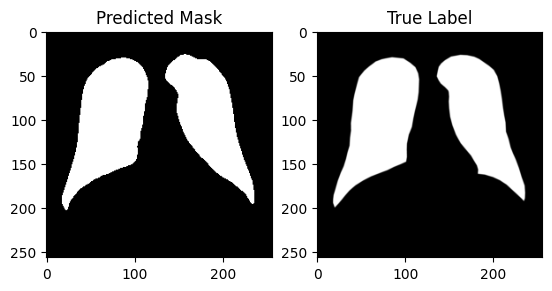

Loss for batch 0: <built-in method item of Tensor object at 0x7f5c2e550c20>


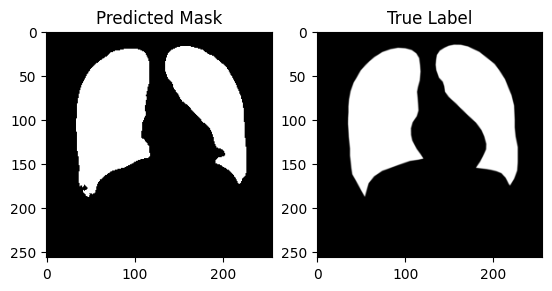

Loss for batch 1: <built-in method item of Tensor object at 0x7f5c2e5dd990>


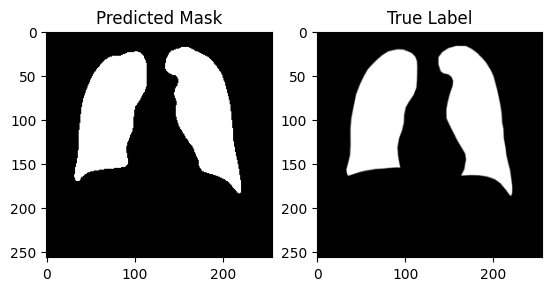

Loss for batch 2: <built-in method item of Tensor object at 0x7f5c2b30f740>


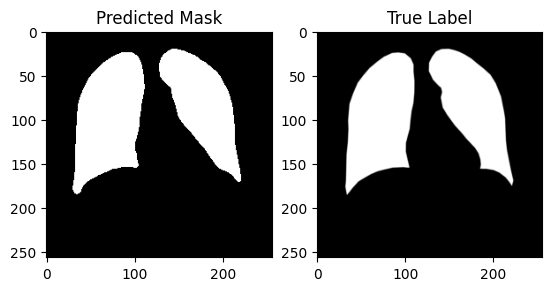

Loss for batch 3: <built-in method item of Tensor object at 0x7f5c297fbe20>


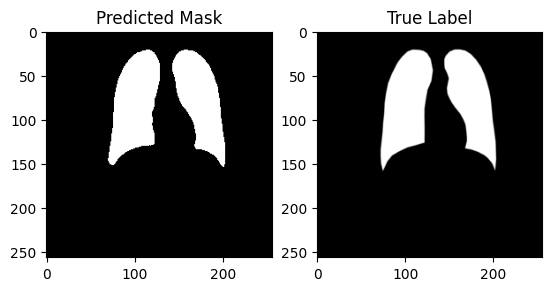

Loss for batch 4: <built-in method item of Tensor object at 0x7f5c297e10d0>


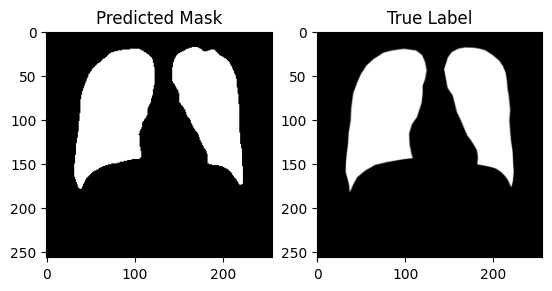

Loss for batch 5: <built-in method item of Tensor object at 0x7f5c2954e570>


In [10]:
model.eval()  # Set the model to evaluation mode
i = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        if i > 5:
          break

        outputs = model(inputs)

        # Calculate the loss
        loss = loss_fn(outputs, labels)

        # Threshold the outputs at 0.5 to get the final binary mask
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        # Convert the predicted masks and labels to CPU and numpy, and squeeze to remove the batch dimension
        predicted_np = predicted.cpu().numpy().squeeze()
        labels_np = labels.cpu().numpy().squeeze()

        # Display the first mask and label in the batch
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(predicted_np[0], cmap='gray')
        ax[0].title.set_text('Predicted Mask')
        ax[1].imshow(labels_np[0], cmap='gray')
        ax[1].title.set_text('True Label')
        plt.show()

        # Print the loss for this batch
        print(f'Loss for batch {i}: {loss.item}')

        i += 1

In [ ]:
model.eval()  # Set the model to evaluation mode
i = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        if i > 6:
          break

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        predicted = (torch.sigmoid(outputs) > 0.5).float()

        predicted_np = predicted.cpu().numpy().squeeze()
        labels_np = labels.cpu().numpy().squeeze()

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(predicted_np[0], cmap='gray')
        ax[0].title.set_text('Predicted Mask')
        ax[1].imshow(labels_np[0], cmap='gray')
        ax[1].title.set_text('True Label')
        plt.show()

        # Print the loss for this batch
        print(f'Loss for batch {i}: {loss.item}')

        i += 1
